# Flow of Incompressible Fluid  

![Problem Defenition](./fig/img.png)

## Viscosity of fluid : $\mu = 0.02kg \cdot (m \cdot sec)^{-1}$
## Densitoy if fluid : $\rho = 1kg \cdot m^{3}$


$$
\large
\begin{equation}
\begin{aligned}
u(0,y) &= u_{in}= y(H-y) \frac{4}{H^2} \\
v(0,y) &= 0
\tag{1}
\end{aligned}
\end{equation}
$$

## ● No slip Condition
## ● Pressure of outlet equals to zero
$$
\large
\begin{equation}
\begin{aligned}
& p(1,y) = 0 \\
& u(x,y) = v(x,y) = 0 \ \ @\ wall\ and\ cylinder\ surface
\tag{2}
\end{aligned}
\end{equation}
$$
## ● Continuity Equation
$$
\large
\nabla\ \cdot\ \mathbf{V} = 0 \ (incompressible\  flow)
\tag{3}
$$

## ● Navier-Stokes Equation
$$
\large
\rho(\mathbf{V} \cdot \nabla)\mathbf{V} = -\nabla p + \mu \nabla^2 \mathbf{V}
\tag{4}
$$
## Or, Cauchy momentum equation
$$
\large
\rho(\mathbf{V} \cdot \nabla)\mathbf{V} = \nabla \cdot \sigma \tag{5}
$$

## When,
$$
\large
\sigma = -p \bar{\mathbf{I}} + \mu ( \nabla \mathbf{V}+(\nabla \mathbf{V})^T ) \tag{6}
$$

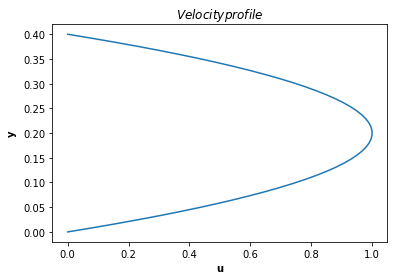

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# inlet flow velocity profile
def inlet_vel(y):
    return 4.0 * y * (0.4 - y) / (0.4 ** 2)

y = np.linspace(0, 0.4, 50)

vel_y = inlet_vel(y)
plt.plot(vel_y, y)
plt.xlabel("$\mathbf{u}$")
plt.ylabel("$\mathbf{y}$")
plt.title("$Velocity profile$")
plt.show()

In [2]:
# Nerual Network
import torch
import torch.nn as nn
from torch.autograd import grad, Variable

print(torch.backends.cuda.matmul.allow_tf32)
torch.backends.cuda.matmul.allow_tf32 = False

torch.set_default_dtype(torch.float64)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),            
            nn.Linear(40, 6),
        )
        self.net.apply(weights_init)
    
    def forward(self, xy):    
        return self.net(xy)
        
class PINN:
    mu = 0.02
    rho = 1
    def __init__(self) -> None:
        self.net = DNN().to(device)
        self.iter = 0
        self.adam = torch.optim.Adam(self.net.parameters(), lr = 5e-4)
        self.lbfgs = torch.optim.LBFGS(
            self.net.parameters(),
            lr=1.0,
            max_iter=20000,
            max_eval=20000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )
    
    def predict(self, xy):
        out = self.net(xy)
        
        u = out[:, 0:1]
        v = out[:, 1:2]
        p = out[:, 2:3]
        sig_xx = out[:, 3:4]
        sig_xy = out[:, 4:5]
        sig_yy = out[:, 5:6]                
        return u, v, p, sig_xx, sig_xy, sig_yy

    def f(self, xy):
        x = Variable(xy[:, 0:1], requires_grad=True).to(device)
        y = Variable(xy[:, 1:2], requires_grad=True).to(device)
        
        u, v, p, sig_xx, sig_xy, sig_yy = self.predict(torch.cat((x,y), dim=1))
                
        u_x = grad(u.sum(), x, create_graph=True)[0]
        u_y = grad(u.sum(), y, create_graph=True)[0]
        v_x = grad(v.sum(), x, create_graph=True)[0]
        v_y = grad(v.sum(), y, create_graph=True)[0]
        sig_xx_x = grad(sig_xx.sum(), x, create_graph=True)[0]
        sig_yy_y = grad(sig_yy.sum(), y, create_graph=True)[0]
        sig_xy_x = grad(sig_xy.sum(), x, create_graph=True)[0]
        sig_xy_y = grad(sig_xy.sum(), y, create_graph=True)[0]

        # Continuity Eqn for incompressible
        f0 = u_x + v_y
        # f6 = p + (sig_xx+sig_yy)/2
                
        # Navier-Stokes
        f1 = self.rho * (u * u_x + v * u_y) - sig_xx_x - sig_xy_y
        f2 = self.rho * (u * v_x + v * v_y) - sig_xy_x - sig_yy_y
        
        # Cauchy stress tensor
        f3 = -p + 2*self.mu*u_x - sig_xx
        f4 = -p + 2*self.mu*v_y - sig_yy
        f5 = self.mu * (u_y + v_x) - sig_xy
        return (f0, f1, f2, f3, f4, f5)

    def loss_fn(self, f, u_pred, v_pred, u_sol, v_sol, outlet_p_pred):
        loss_bnd = torch.mean(torch.square(u_pred - u_sol)) +\
                    torch.mean(torch.square(v_pred - v_sol))
        
        loss_outlet = torch.mean(torch.square(outlet_p_pred))    
        loss_collocation = sum([torch.mean(torch.square(f_)) for f_ in f])

        return loss_bnd, loss_outlet, loss_collocation
    
    def closure(self):
        # xy_col, xy_bnd, uv_bnd, outlet_xy, outlet_p
        self.adam.zero_grad()
        self.lbfgs.zero_grad()
        # boundary [inlet, wall, cylinder]
        u_pred, v_pred, _, _, _, _ = self.predict(xy_bnd)
        u_sol = uv_bnd[:, 0:1]
        v_sol = uv_bnd[:, 1:2]
        # outlet
        _, _, outlet_p_pred, _, _, _  = self.predict(outlet_xy)
        # collocation
        f = self.f(xy_col)
        
        # calc loss
        loss_bnd, loss_outlet, loss_collocation = self.loss_fn(f, u_pred, v_pred, u_sol, v_sol, outlet_p_pred)
        loss = loss_bnd + loss_outlet + loss_collocation
        loss.backward()
        self.iter += 1
        msg = f"\r{self.iter}, " + \
            f"loss : {loss.item():.3e}, " +\
            f"boundary : {loss_bnd.item():.3e}, " +\
            f"outlet : {loss_outlet.item():.3e}, " +\
            f"collocation : {loss_collocation.item():.3e}"
        print(msg, end = "")
        if self.iter % 500 == 0:
            print("")
            torch.save(self.net.state_dict(), "weight.pt")
        return loss
        
        

True


In [3]:
from pyDOE import lhs

# Data Prepareation
N_b = 200   # inlet & outlet
N_w = 400   # wall
N_s = 200   # surface
N_c = 40000 # collocation
N_r = 10000

x_min = 0.0
x_max = 1.0
y_min = 0.0
y_max = 0.4
r = 0.05
xc = 0.2
yc = 0.2

def remove_pt_inside_cyl(xy_col, xc, yc, r):
    dst = np.array([((xy[0] - xc) ** 2 + (xy[1] - yc) ** 2) ** 0.5 for xy in xy_col])
    return xy_col[dst > r, :]

def getData():    
    # inlet, v=0 & inlet velocity        
    inlet_xy = np.linspace([x_min, y_min], [x_min, y_max], N_b)
    inlet_u = inlet_vel(inlet_xy[:, 1]).reshape(-1, 1)
    inlet_v = np.zeros((N_b, 1))
    inlet_uv = np.concatenate([inlet_u, inlet_v], axis=1)

    # outlet, p=0
    outlet_xy = np.linspace([x_max, y_min], [x_max, y_max], N_b)
    outlet_p = np.zeros((N_b, 1))
    
    # wall, u=v=0    
    wallup_xy = np.linspace([x_min, y_max], [x_max, y_max], N_w)
    walldn_xy = np.linspace([x_min, y_min], [x_max, y_min], N_w)
    wallup_uv = np.zeros((N_w, 2))
    walldn_uv = np.zeros((N_w, 2))

    # cylinder surface, u=v=0
    theta = np.linspace(0.0, 2 * np.pi, N_s)
    cyl_x = (r * np.cos(theta) + xc).reshape(-1, 1)
    cyl_y = (r * np.sin(theta) + yc).reshape(-1, 1)
    cyl_xy = np.concatenate([cyl_x, cyl_y], axis=1)
    cyl_uv = np.zeros((N_s, 2))
    
    # all boundary except outlet
    xy_bnd = np.concatenate([inlet_xy, wallup_xy, walldn_xy, cyl_xy], axis=0)
    uv_bnd = np.concatenate([inlet_uv, wallup_uv, walldn_uv, cyl_uv], axis=0)

    # Collocation
    x_col = np.random.uniform(x_min, x_max, [N_c, 1])
    y_col = np.random.uniform(y_min, y_max, [N_c, 1])
    xy_col = np.concatenate([x_col, y_col], axis=1)
    # refine points around cylider
    x_col_refine = np.random.uniform(xc-2*r, xc+2*r, [N_r, 1])
    y_col_refine = np.random.uniform(yc-2*r, yc+2*r, [N_r, 1])
    xy_col_refine = np.concatenate([x_col_refine, y_col_refine], axis=1)
    xy_col = np.concatenate([xy_col, xy_col_refine], axis=0)
     
    # remove collocation points inside the cylinder
    xy_col = remove_pt_inside_cyl(xy_col, xc=xc, yc=yc, r=r)
    
    # concatenate all xy for collocation
    xy_col = np.concatenate((xy_col, xy_bnd, outlet_xy), axis=0)

    # convert to tensor
    xy_col = torch.tensor(xy_col, dtype=torch.float32).to(device)
    xy_bnd = torch.tensor(xy_bnd, dtype=torch.float32).to(device)
    uv_bnd = torch.tensor(uv_bnd, dtype=torch.float32).to(device)
    outlet_xy = torch.tensor(outlet_xy, dtype=torch.float32).to(device)
    outlet_p = torch.tensor(outlet_p, dtype=torch.float32).to(device)
    return xy_col, xy_bnd, uv_bnd, outlet_xy, outlet_p
    

In [4]:
xy_col, xy_bnd, uv_bnd, outlet_xy, outlet_p = getData()

In [5]:
%%time 
pinn = PINN()
for i in range(10000):
    pinn.closure()
    pinn.adam.step()
pinn.lbfgs.step(pinn.closure)

500, loss : 5.987e-02, boundary : 5.933e-02, outlet : 1.523e-06, collocation : 5.391e-04
1000, loss : 5.388e-02, boundary : 5.322e-02, outlet : 5.369e-07, collocation : 6.592e-04
1500, loss : 4.500e-02, boundary : 4.429e-02, outlet : 1.399e-05, collocation : 6.996e-04
2000, loss : 4.205e-02, boundary : 4.126e-02, outlet : 5.359e-06, collocation : 7.779e-04
2500, loss : 3.964e-02, boundary : 3.856e-02, outlet : 3.377e-06, collocation : 1.078e-03
3000, loss : 3.766e-02, boundary : 3.632e-02, outlet : 1.748e-06, collocation : 1.343e-03
3500, loss : 3.616e-02, boundary : 3.476e-02, outlet : 1.302e-06, collocation : 1.399e-03
4000, loss : 3.470e-02, boundary : 3.294e-02, outlet : 2.779e-06, collocation : 1.749e-03
4500, loss : 3.304e-02, boundary : 3.124e-02, outlet : 1.390e-06, collocation : 1.798e-03
5000, loss : 3.171e-02, boundary : 2.974e-02, outlet : 5.878e-07, collocation : 1.965e-03
5500, loss : 3.068e-02, boundary : 2.847e-02, outlet : 4.063e-07, collocation : 2.208e-03
6000, loss 

tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)

In [6]:
x = np.arange(x_min, x_max, 0.001)
y = np.arange(y_min, y_max, 0.001)
x_, y_ = np.meshgrid(x, y)
x = x_.reshape(-1,1)
y = y_.reshape(-1,1)

dst_from_cyl = np.array([np.sqrt((x_ - xc) ** 2 + (y_ - yc) **2) for x_, y_ in zip(x, y)])
cyl_mask = dst_from_cyl > r

x_ts = torch.tensor(x, dtype=torch.float32).to(device)
y_ts = torch.tensor(y, dtype=torch.float32).to(device)
xy_ts = torch.cat((x_ts, y_ts), dim=1)

with torch.no_grad():
    u, v, p, sig_xx, sig_xy, sig_yy = pinn.predict(xy_ts)
    u = u.cpu().numpy()
    u = np.where(cyl_mask, u, np.nan).reshape(y_.shape)
    v = v.cpu().numpy()
    v = np.where(cyl_mask, v, np.nan).reshape(y_.shape)
    p = p.cpu().numpy()
    p = np.where(cyl_mask, p, np.nan).reshape(y_.shape)



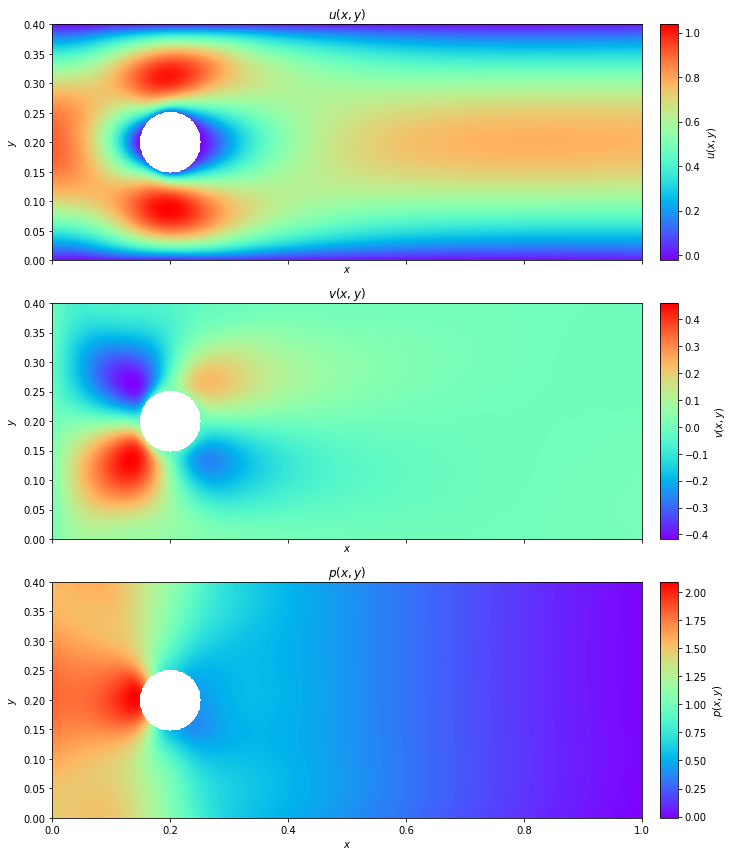

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(3, 1, figsize=(11, 12), sharex = True)

data = (u, v, p)
labels = ["$u(x,y)$", "$v(x,y)$", "$p(x,y)$"]
for i in range(3):
    ax = axes[i]
    im = ax.imshow(data[i], cmap = "rainbow", extent=[x_min, x_max, y_min, y_max])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size = "3%", pad="3%")
    fig.colorbar(im, cax = cax, label = labels[i])
    ax.set_title(labels[i])
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_aspect("equal")
fig.tight_layout()
fig.savefig("data.png", dpi=500)

In [ ]:
loss : 6.401e-03, boundary : 2.564e-03, outlet : 8.288e-06, collocation : 3.829e-03
Wall time: 18min 13s